# Model 12
## Model 11 but try solwing overfitting
Differences from Model 11: kernel_size changed to 0.03, Adam learning rate changed to 0.003 and batch size changed to 128, epoch changed to 200.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.models import Sequential
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

In [2]:
df_oyak=pd.read_csv(r"C:\Users\denem\Downloads\OykBlFarnSstmFn.csv")

In [3]:
df_oyak.head()

,time,xVRMS,yVRMS,zVRMS,temp,cf,maxCf
0,2022-06-27 11:35:00,2.3975,1.7435,0.448,50.4,2.685,NaN
1,2022-06-27 11:40:00,2.3110,1.8080,0.524,49.9,2.480,NaN
2,2022-06-27 11:45:00,2.3520,1.7020,0.451,50.5,2.570,NaN
3,2022-06-27 11:55:00,2.4500,1.6380,0.469,50.4,2.460,NaN
4,2022-06-27 12:00:00,2.3680,1.7200,0.436,50.8,2.290,NaN


In [4]:
new_df_oyk=df_oyak.sort_values("time")

In [5]:
df2_x=new_df_oyk["xVRMS"]

In [6]:
df2_x.isnull().sum()

3

In [7]:
df2_x=df2_x.fillna(df2_x.mean())

In [8]:
df2_x.isnull().sum()

0

In [9]:
df2_x.index = pd.to_datetime(new_df_oyk["time"])

In [10]:
df2_x.tail()

time
2023-04-24 21:10:00    4.53544
2023-04-24 21:15:00    4.50937
2023-04-24 21:20:00    4.41924
2023-04-24 21:25:00    4.49352
2023-04-24 21:30:00    4.53100
Name: xVRMS, dtype: float64

In [11]:
type(df2_x)

pandas.core.series.Series

In [12]:
def clean_limit(df_column, low_limit, up_limit=None):
    if up_limit is None:
        filtered = df_column[(df_column >= low_limit)]
        
    else:
        filtered = df_column.loc[(df_column >= low_limit) & (df_column <= up_limit)]
    return filtered

In [13]:
df2_x=clean_limit(df2_x,low_limit=0.5)

In [14]:
len(df2_x)

58688

## 3 sigma

In [15]:
process_clm = df2_x
process_clm_mean = process_clm.mean()
process_clm_std = process_clm.std()

up_limit = process_clm_mean + 3 * process_clm_std
low_limit = process_clm_mean - 3 * process_clm_std

process_clm_mean,process_clm_std,up_limit,low_limit

(3.522406619639381, 0.9837945762157837, 6.473790348286732, 0.5710228909920296)

In [16]:
df2_x=clean_limit(df2_x,low_limit=low_limit,up_limit=up_limit)

In [34]:
len(df2_x)

58328

In [18]:
max_s=df2_x.idxmax()
df2_x[ max_s]

6.473

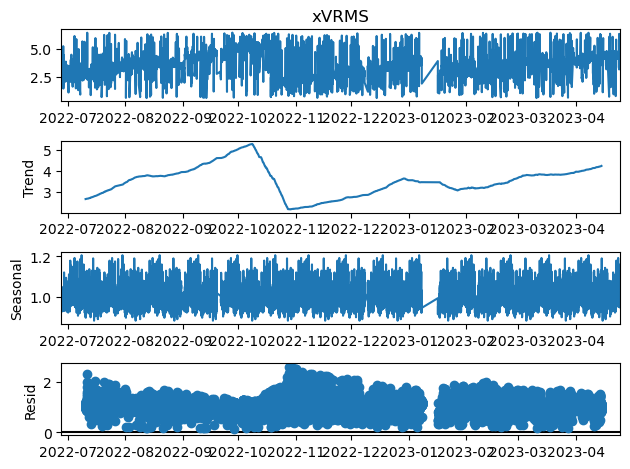

In [19]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df2_x, model='multiplicative',period=4096)
result.plot()
plt.show()

In [20]:
WINDOW_SIZE=5

In [21]:
def df_to_X_y(df, window_size=5):
  """
  Converts a pandas DataFrame to a tuple of NumPy arrays, where X is the input data and y is the target data.

  Args:
    df: A pandas DataFrame.
    window_size: The size of the sliding window.

  Returns:
    A tuple of NumPy arrays, where X is the input data and y is the target data.
  """

  # Convert the DataFrame to a NumPy array.
  df_as_np = df.to_numpy()

  # Create the input and target data.
  X = []
  y = []
  for i in range(len(df_as_np) - window_size):
    row = df_as_np[i:i + window_size]
    X.append(row)
    label = df_as_np[i + window_size]
    y.append(label)

  # Return the input and target data as NumPy arrays.
  return np.array(X), np.array(y)

In [22]:
X,y =df_to_X_y(df2_x,WINDOW_SIZE)
X.shape,y.shape

((58323, 5), (58323,))

In [23]:
total_size = len(X)
train_size = int(total_size * 0.8)
val_size = int(total_size * 0.1)

X_train, y_train = X[:train_size], y[:train_size]  # %80
X_val, y_val = X[train_size:train_size+val_size], y[train_size:train_size+val_size]  # %10
X_test, y_test = X[train_size+val_size:], y[train_size+val_size:]  # %10

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((46658, 5), (46658,), (5832, 5), (5832,), (5833, 5), (5833,))

In [24]:
# Assuming X_train, X_val, and X_test are your input features
# Assuming y_train, y_val, and y_test are your target variables

# Create a MinMaxScaler object for the input features
scaler = MinMaxScaler()

# Fit the scaler on the training input features
scaler.fit(X_train)

# Apply normalization to the input features
X_train_normalized = scaler.transform(X_train)
X_val_normalized = scaler.transform(X_val)
X_test_normalized = scaler.transform(X_test)

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

In [26]:
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import EarlyStopping
from keras import regularizers
from keras.engine.input_layer import InputLayer

# Rest of your code
model12 = Sequential()
model12.add(InputLayer((WINDOW_SIZE, 1)))
model12.add(LSTM(128, return_sequences=True, kernel_regularizer=regularizers.l2(0.03)))
model12.add(Dropout(0.2))
model12.add(LSTM(64, kernel_regularizer=regularizers.l2(0.03)))
model12.add(Dropout(0.2))
model12.add(Dense(8, activation='relu', kernel_regularizer=regularizers.l2(0.03)))
model12.add(Dense(1, activation='linear'))

# Compile the model
model12.compile(loss="mean_squared_error", optimizer=Adam(learning_rate=0.003))
best_model_weights = ModelCheckpoint("model12.h5", monitor="val_loss", save_best_only=True)
# Apply early stopping to prevent overfitting
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)

# Fit the model
model12.fit(X_train_normalized, y_train, batch_size=128, epochs=200, validation_data=(X_val_normalized, y_val), callbacks=[best_model_weights, early_stopping])



Epoch 1/200
365/365 [==============================] - 10s 18ms/step - loss: 0.9496 - val_loss: 0.2637
Epoch 2/200
365/365 [==============================] - 6s 15ms/step - loss: 0.2678 - val_loss: 0.2191
Epoch 3/200
365/365 [==============================] - 6s 17ms/step - loss: 0.2323 - val_loss: 0.2187
Epoch 4/200
365/365 [==============================] - 6s 16ms/step - loss: 0.2216 - val_loss: 0.2074
Epoch 5/200
365/365 [==============================] - 6s 16ms/step - loss: 0.1974 - val_loss: 0.1875
Epoch 6/200
365/365 [==============================] - 6s 17ms/step - loss: 0.1837 - val_loss: 0.1777
Epoch 7/200
365/365 [==============================] - 6s 15ms/step - loss: 0.1684 - val_loss: 0.1828
Epoch 8/200
365/365 [==============================] - 6s 15ms/step - loss: 0.1620 - val_loss: 0.1641
Epoch 9/200
365/365 [==============================] - 6s 16ms/step - loss: 0.1565 - val_loss: 0.1704
Epoch 10/200
365/365 [==============================] - 6s 15ms/step - loss: 0.15

In [27]:
train_predictions = model12.predict(X_train_normalized).flatten()
train_results = pd.DataFrame(data={"Train Predictions": train_predictions, "Actuals": y_train.flatten()})
train_results[:30]

1459/1459 [==============================] - 3s 2ms/step


,Train Predictions,Actuals
0,2.599092,2.3800
1,2.578684,2.2610
2,2.587048,2.3590
3,2.598189,2.5840
4,2.560695,2.6590
5,2.615473,2.5500
6,2.652852,2.5930
7,2.707372,2.7340
8,2.786335,2.6375
9,2.841584,2.7020


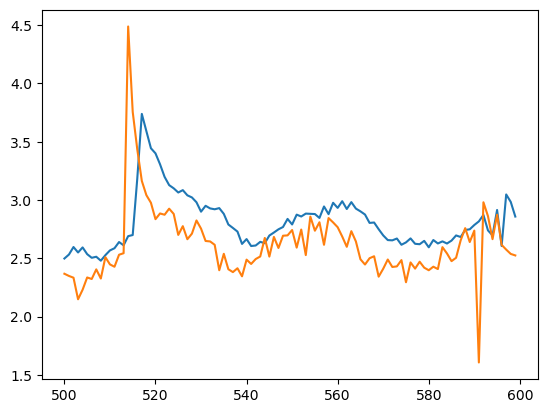

In [28]:
plt.plot(train_results["Train Predictions"][500:600])
plt.plot(train_results["Actuals"][500:600])

In [29]:
val_predictions=model12.predict(X_val_normalized).flatten()
val_results=pd.DataFrame(data={"Val Predictions": val_predictions,"Actuals":y_val.flatten()})
val_results[:30]

183/183 [==============================] - 0s 2ms/step


,Val Predictions,Actuals
0,3.948474,3.79186
1,3.801164,3.67819
2,3.786780,3.83377
3,3.781197,3.81646
4,3.774678,3.78432
5,3.817885,3.84871
6,3.828100,4.01990
7,3.828440,4.02672
8,3.887624,4.00919
9,3.976049,3.99258


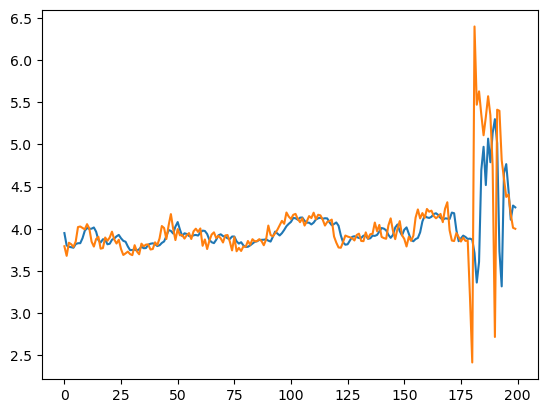

In [30]:
plt.plot(val_results["Val Predictions"][:200])
plt.plot(val_results["Actuals"][:200])


In [31]:
test_predictions=model12.predict(X_test_normalized).flatten()
test_results=pd.DataFrame(data={"Test Predictions": test_predictions,"Actuals":y_test.flatten()})
test_results[:30]

183/183 [==============================] - 0s 2ms/step


,Test Predictions,Actuals
0,4.044016,4.02613
1,4.030616,4.03413
2,4.052787,4.02290
3,4.032654,4.04984
4,4.013318,4.03620
5,4.019304,4.05415
6,4.026936,4.04369
7,4.029825,3.93851
8,4.032231,3.98242
9,4.006411,4.08432


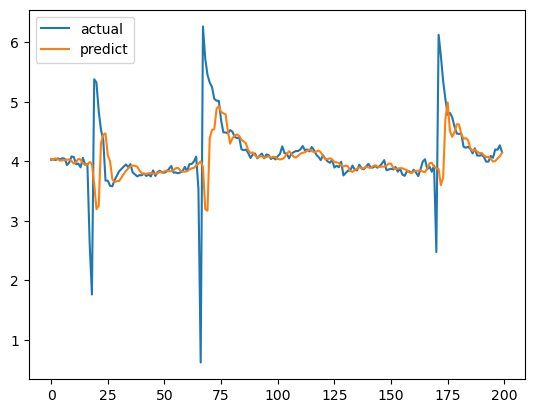

In [32]:
plt.plot(test_results["Actuals"][:200])
plt.plot(test_results["Test Predictions"][:200])
plt.legend(labels=["actual", "predict"])

In [33]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Get the model's predictions
y_train_pred = train_predictions
y_val_pred = val_predictions
y_test_pred =test_predictions

# Calculate the regression metrics
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_val = mean_absolute_error(y_val, y_val_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)

mse_train = mean_squared_error(y_train, y_train_pred)
mse_val = mean_squared_error(y_val, y_val_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

rmse_train = np.sqrt(mse_train)
rmse_val = np.sqrt(mse_val)
rmse_test = np.sqrt(mse_test)

r2_train = r2_score(y_train, y_train_pred)
r2_val = r2_score(y_val, y_val_pred)
r2_test = r2_score(y_test, y_test_pred)

# Print the results
print("Regression Metrics:")
print("MAE - Train:", mae_train)
print("MAE - Validation:", mae_val)
print("MAE - Test:", mae_test)
print("MSE - Train:", mse_train)
print("MSE - Validation:", mse_val)
print("MSE - Test:", mse_test)
print("RMSE - Train:", rmse_train)
print("RMSE - Validation:", rmse_val)
print("RMSE - Test:", rmse_test)
print("R^2 Score - Train:", r2_train)
print("R^2 Score - Validation:", r2_val)
print("R^2 Score - Test:", r2_test)


Regression Metrics:
MAE - Train: 0.2165830626112821
MAE - Validation: 0.15148608886302745
MAE - Test: 0.12009630797402027
MSE - Train: 0.13284129280238086
MSE - Validation: 0.13538063434001985
MSE - Test: 0.09927225974450299
RMSE - Train: 0.3644739946860144
RMSE - Validation: 0.36794107454865627
RMSE - Test: 0.31507500653733705
R^2 Score - Train: 0.8591261509665982
R^2 Score - Validation: 0.395617293555769
R^2 Score - Test: 0.4538564344418421


In [35]:
df2_x.axes

[DatetimeIndex(['2022-06-27 11:35:00', '2022-06-27 11:40:00',
                '2022-06-27 11:45:00', '2022-06-27 11:55:00',
                '2022-06-27 12:00:00', '2022-06-27 12:05:00',
                '2022-06-27 12:15:00', '2022-06-27 12:50:00',
                '2022-06-27 12:55:00', '2022-06-27 13:00:00',
                ...
                '2023-04-24 20:45:00', '2023-04-24 20:50:00',
                '2023-04-24 20:55:00', '2023-04-24 21:00:00',
                '2023-04-24 21:05:00', '2023-04-24 21:10:00',
                '2023-04-24 21:15:00', '2023-04-24 21:20:00',
                '2023-04-24 21:25:00', '2023-04-24 21:30:00'],
               dtype='datetime64[ns]', name='time', length=58328, freq=None)]